## Setup and Data Prep

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset


full_dataset = SurrealTrainDataset('/home/s94zalek/shape_matching/data/SURREAL_full/incomplete_datasets/125_125_250_0_28')

# select 90% of the dataset for training and 10% for validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

print(f'Training dataset size: {train_size}', f'Validation dataset size: {val_size}')

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

train_dataset[0][0].shape, train_dataset[0][1].shape

Fmap dim: 28
Training dataset size: 56250 Validation dataset size: 6250


(torch.Size([1, 28, 28]), torch.Size([1, 28]))

Random indices: [37946  7402 31175]
Shape of fmap/eval: torch.Size([1, 28, 28]) torch.Size([1, 28])
Min/max of fmap at index 1: tensor(-1.) tensor(1.)
Min/max of fmap at index 2: tensor(-1.) tensor(1.)


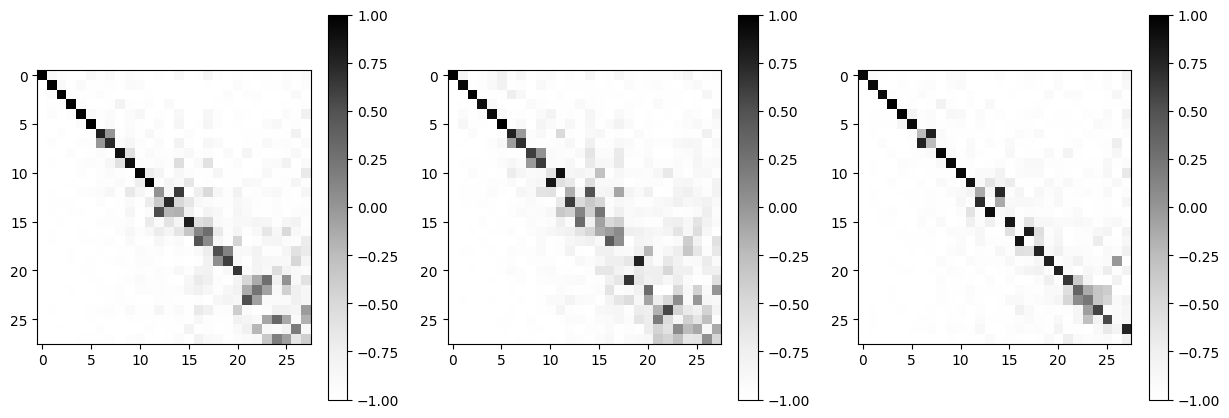

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.randint(0, len(train_dataset), 3)
print('Random indices:', rand_idx)

print('Shape of fmap/eval:', train_dataset[rand_idx[0]][0].shape, train_dataset[rand_idx[0]][1].shape)
print('Min/max of fmap at index 1:', train_dataset[rand_idx[1]][0][0].min(), train_dataset[rand_idx[1]][0][0].max())
print('Min/max of fmap at index 2:', train_dataset[rand_idx[2]][0][0].min(), train_dataset[rand_idx[2]][0][0].max())

ax_0 = ax[0].imshow(train_dataset[rand_idx[0]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(train_dataset[rand_idx[1]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(train_dataset[rand_idx[2]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])

plt.show()

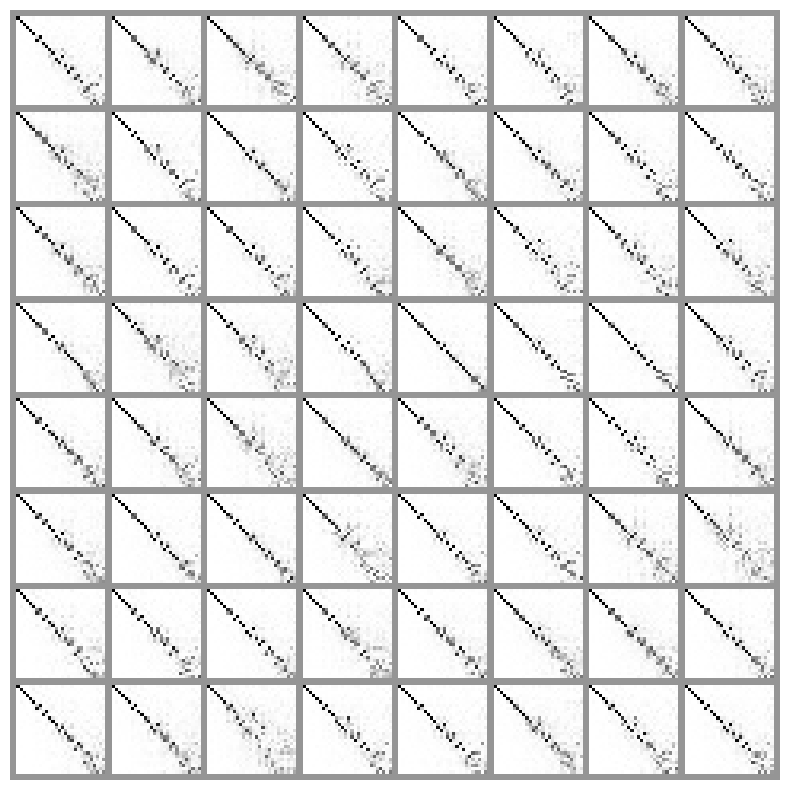

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(torchvision.utils.make_grid(
    torch.stack([train_dataset[i][0] for i in range(64)]),
    nrow=8, value_range=(-1, 1)
    )[0], cmap='Greys')
# disable the axis
ax.axis('off')
plt.show()

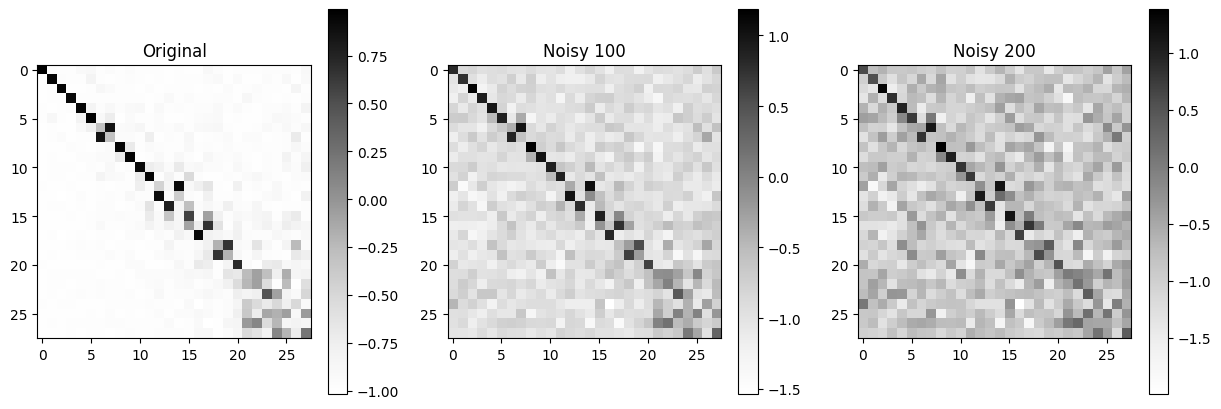

In [5]:
# add noise
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)

rand_idx = np.random.randint(0, len(train_dataset), 1)
rand_fmap = train_dataset[rand_idx[0]][0]

noise = torch.randn_like(rand_fmap)
timesteps = torch.tensor([0, 100, 200]).long()
noisy_fmap = noise_scheduler.add_noise(rand_fmap, noise, timesteps)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(noisy_fmap[0], cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])
ax[0].set_title('Original')

ax_1 = ax[1].imshow(noisy_fmap[1], cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])
ax[1].set_title(f'Noisy {timesteps[1]}')

ax_2 = ax[2].imshow(noisy_fmap[2], cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])
ax[2].set_title(f'Noisy {timesteps[2]}')

plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

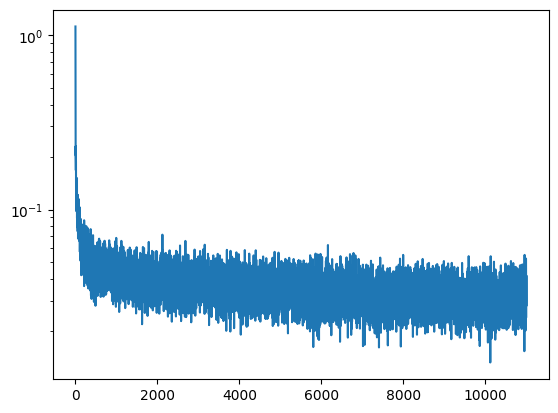

In [6]:
from diffusers import UNet2DConditionModel, UNet2DModel
import my_code.diffusion_training.train_model as train_model

model_unconditional = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    ).to(device)


model_unconditional, losses = train_model.train(
    model=model_unconditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=True,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses)
plt.yscale('log')

plt.show()

Once training finishes, we can sample some images feeding in different labels as our conditioning:

  0%|          | 0/1000 [00:00<?, ?it/s]

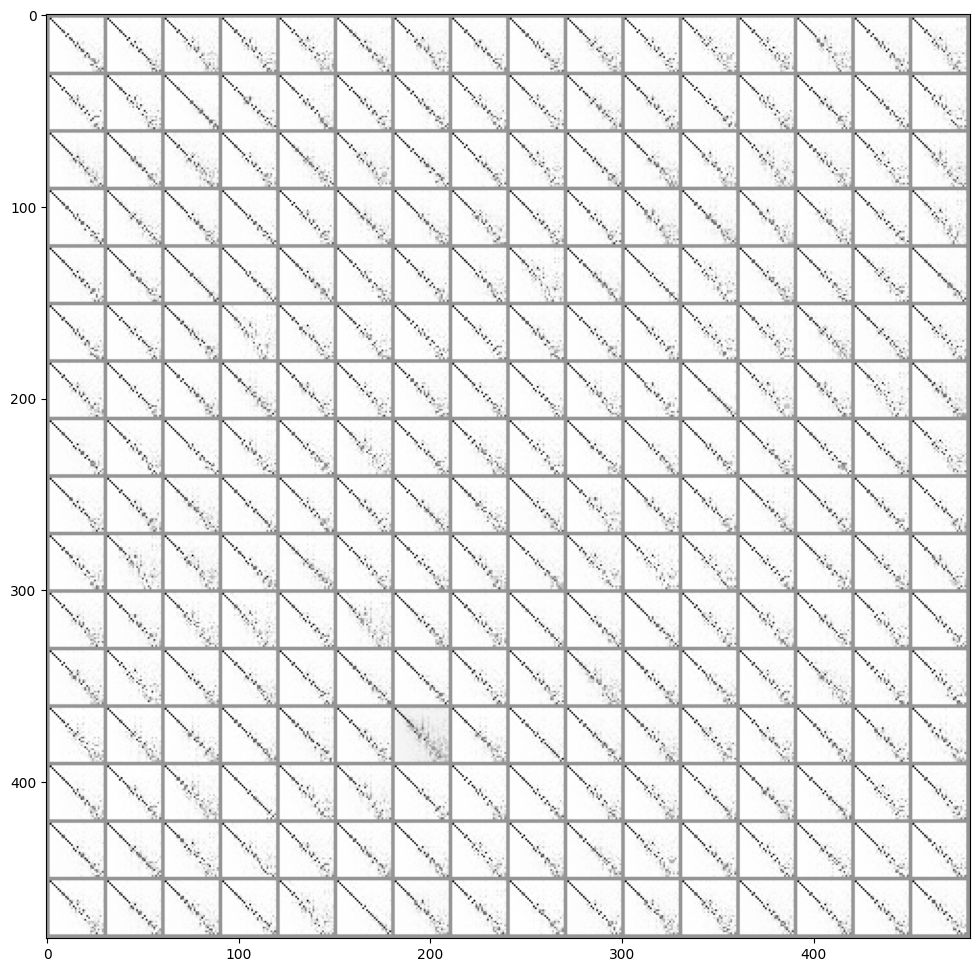

In [7]:
import my_code.diffusion_training.sample_model as sample_model

x_uncond = sample_model.sample(
    model=model_unconditional,
    n_samples=256,
    noise_shape=28,
    conditioning=None,
    noise_scheduler=noise_scheduler,
    plot_last_steps=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax_plot = ax.imshow(torchvision.utils.make_grid(
    x_uncond.detach().cpu(), nrow=16, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')
# plt.colorbar(ax_plot, ax=ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax_0 = ax[0].imshow(test_dataset[3][0][0].numpy(), cmap='Greys')
# add colorbar
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_uncond[5][0].cpu().numpy(), cmap='Greys')
fig.colorbar(ax_1, ax=ax[1])

In [8]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples
    
inc_inx = evaluate_samples.count_zero_regions(x_uncond, -0.7, 0.2)

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax_0 = ax[0].imshow(x_uncond[inc_inx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
# fig.colorbar(ax_0, ax=ax[0])

# ax_1 = ax[1].imshow(x_uncond[inc_inx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
# fig.colorbar(ax_1, ax=ax[1])

# plt.show()

Incorrect zero regions: 1 / 256 = 0.39%


# Conditional model

  0%|          | 0/25 [00:00<?, ?it/s]

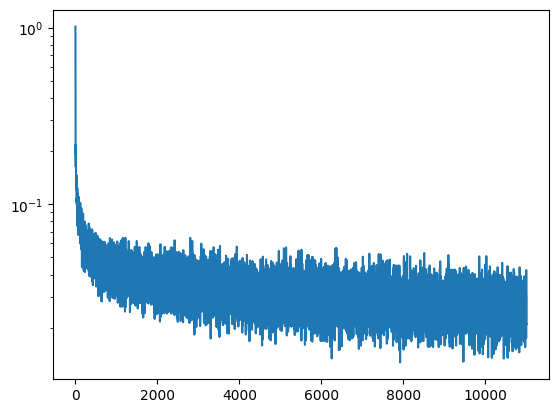

In [13]:
from diffusers import UNet2DConditionModel

class EncoderConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = UNet2DConditionModel(
            sample_size=28,           # the target image resolution
            in_channels=1, # Additional input channels for class cond.
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
              ),
            encoder_hid_dim=28,
        ).to(device)
    
  def forward(self, sample, timestep, conditioning):
    return self.model(sample, timestep, encoder_hidden_states=conditioning)

model_encoder_conditional = EncoderConditionedUnet().to(device)

model_encoder_conditional, losses_encoder_cond = train_model.train(
    model=model_encoder_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses_encoder_cond)
plt.yscale('log')

plt.show()

In [20]:
import importlib
importlib.reload(sample_model)

<module 'my_code.diffusion_training.sample_model' from '/home/s94zalek/shape_matching/my_code/diffusion_training/sample_model.py'>

Sampling 1024 random fmaps


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sum across image
Loss sum: 42472.9531, mean: 41.4775
Random loss sum: 86836.9766, mean: 84.8017
Divided by nonzero count
Loss sum: 225.5618, mean: 0.2203
Random loss sum: 471.4138, mean: 0.4604


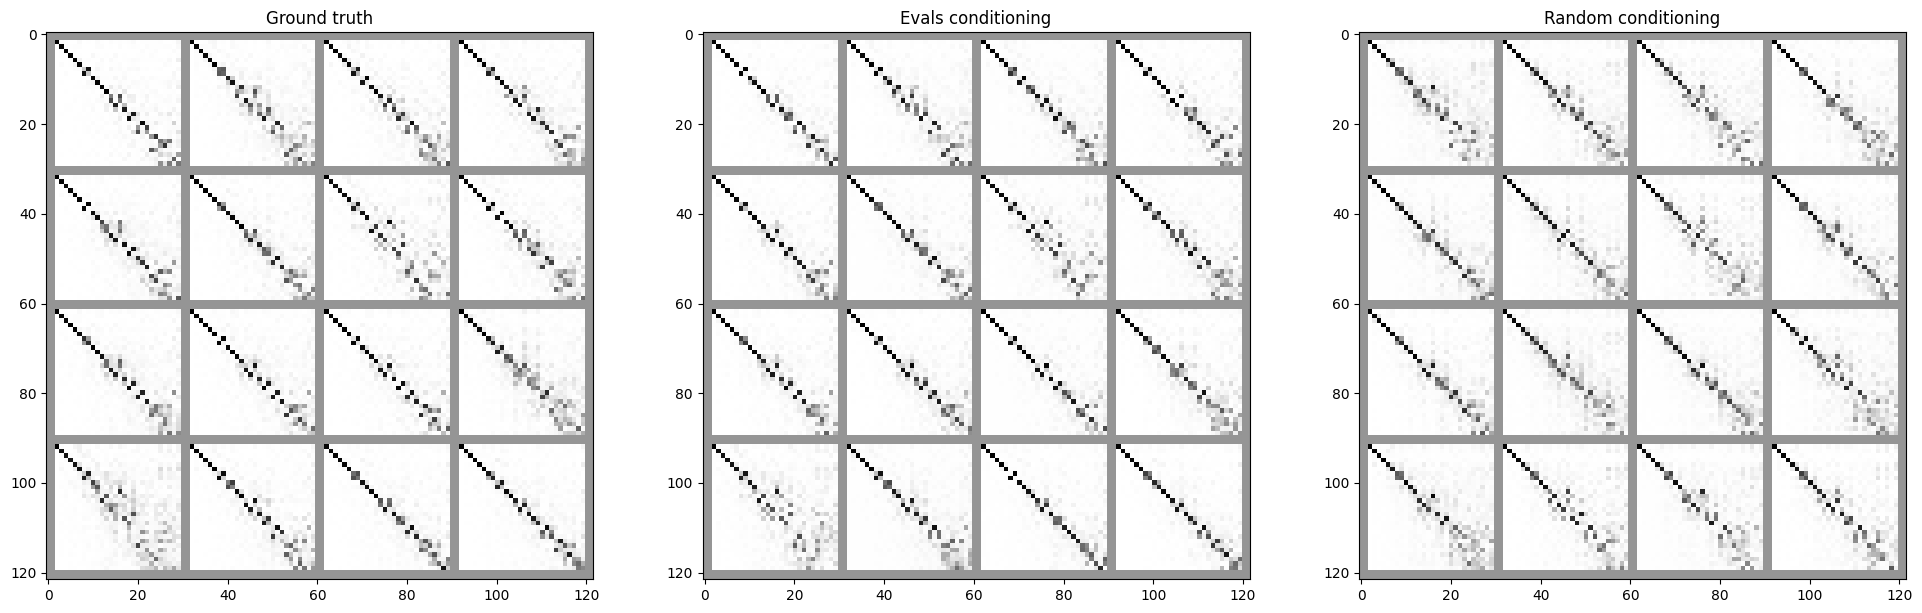

In [21]:
def conditional_loss(x_gt, x_cond, x_rand_cond):
    loss_eval = torch.tensor([])
    loss_random = torch.tensor([])
    nonzero_counts = torch.tensor([])

    for i in range(len(x_cond)):
        gt_fmap = x_gt[i][0]
        pred_fmap = x_cond[i][0]
        pred_fmap_rand = x_rand_cond[i][0]
        
        nonzero_count = (gt_fmap > -0.9).int().sum()
        nonzero_counts = torch.cat((nonzero_counts, nonzero_count.view(1)))
        
        loss_fmap = (gt_fmap - pred_fmap).abs().sum()
        loss_fmap_rand = (gt_fmap - pred_fmap_rand).abs().sum()
        
        loss_eval = torch.cat((loss_eval, loss_fmap.view(1)))
        loss_random = torch.cat((loss_random, loss_fmap_rand.view(1)))
        
    print(f'Sum across image')
    print(f'Loss sum: {torch.sum(loss_eval):.4f}, mean: {torch.mean(loss_eval):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random):.4f}, mean: {torch.mean(loss_random):.4f}')
    
    print(f'Divided by nonzero count')
    print(f'Loss sum: {torch.sum(loss_eval / nonzero_counts):.4f}, mean: {torch.mean(loss_eval / nonzero_counts):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random / nonzero_counts):.4f}, mean: {torch.mean(loss_random / nonzero_counts):.4f}')
    


def conditional_sampling(model, rand_indices):

    print(f"Sampling {len(rand_indices)} random fmaps")

    x_gt = torch.stack([test_dataset[i][0] for i in rand_indices])
    y_gt = torch.stack([test_dataset[i][1] for i in rand_indices])
    y_rand = torch.randn_like(y_gt)

    x_cond = sample_model.sample(model, len(rand_indices), conditioning=y_gt, plot_last_steps=False,
                                 noise_scheduler=noise_scheduler, noise_shape=28).detach().cpu()
    x_rand_cond = sample_model.sample(model, len(rand_indices), conditioning=y_rand, plot_last_steps=False,
                                      noise_scheduler=noise_scheduler, noise_shape=28).detach().cpu()


    conditional_loss(x_gt, x_cond, x_rand_cond)



    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    ax_0 = ax[0].imshow(torchvision.utils.make_grid(
        x_gt[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[0].set_title('Ground truth')

    ax_1 = ax[1].imshow(torchvision.utils.make_grid(
        x_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[1].set_title('Evals conditioning')

    ax_2 = ax[2].imshow(torchvision.utils.make_grid(
        x_rand_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[2].set_title('Random conditioning')

    plt.show()
    
    return x_gt, x_cond, x_rand_cond
    
    
rand_indices = np.random.choice(len(test_dataset), 1024, replace=False)
x_gt, x_cond_encoder, x_rand_cond = conditional_sampling(model_encoder_conditional, rand_indices)

In [ ]:
max_loss = torch.argmax(losses_encoder_cond)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(x_gt[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond_encoder[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_rand_cond[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_2, ax=ax[2])

plt.show()

In [ ]:
inc_inx = count_zero_regions(x_cond, -0.7, 0.2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.choice(inc_inx, 3, replace=False)

ax_0 = ax[0].imshow(x_cond[rand_idx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond[rand_idx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_cond[rand_idx[2]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_2, ax=ax[2])

plt.show()

In [24]:
def plot_sampling_difference(x_gt, x_cond, idx):
        
    fig, ax = plt.subplots(3, 3, figsize=(10, 8))

    for i in range(3):
        ax[i, 0].imshow(x_gt[idx[i]][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 0].set_title('Ground truth')
        
        ax[i, 1].imshow(x_cond[idx[i]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 1].set_title('Evals conditioning')
        
        difference = x_gt[idx[i]][0] - x_cond[idx[i]][0].cpu()
        ax_2 = ax[i, 2].imshow(difference.abs().numpy(),
                        cmap='Greys', vmin=0)
        plt.colorbar(ax_2, ax=ax[i, 2])
        ax[i, 2].set_title(f'Difference {difference.min():.2f} {difference.max():.2f}, {difference.abs().mean():.2f}, {difference.abs().sum():.2f}')
        
        # set suptitle 
        
        
    plt.show()

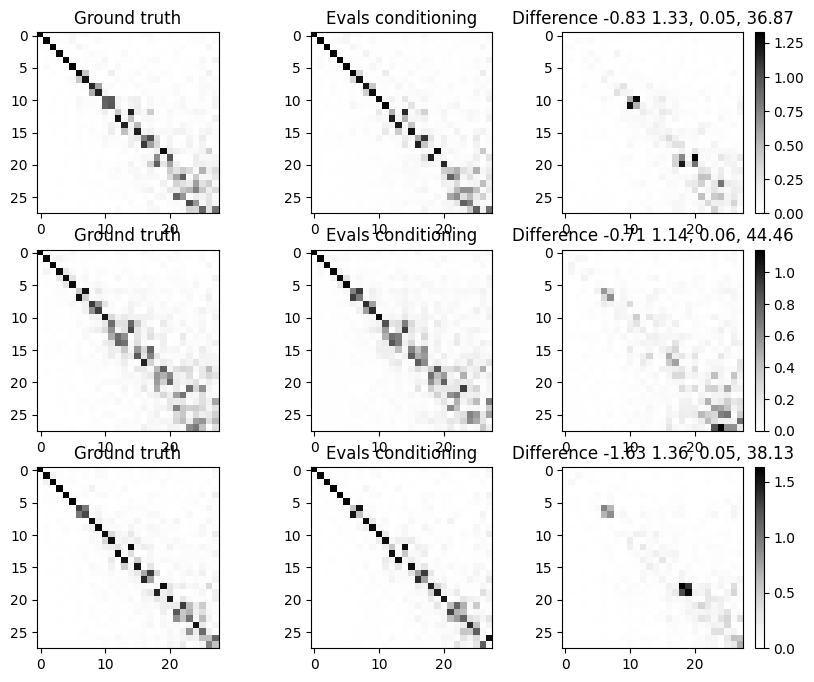

In [25]:
rand_idx = np.random.choice(len(x_gt), 3, replace=False)
plot_sampling_difference(x_gt, x_cond_encoder, rand_idx)

# Conditioning through concatenation

  0%|          | 0/25 [00:00<?, ?it/s]

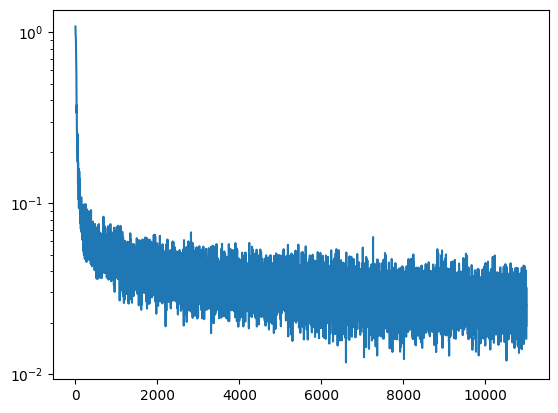

In [26]:
class DiagConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=2, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, sample, timestep, conditioning):

    conditioning_diag = torch.diag_embed(conditioning) # (bs, 28, 28

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((sample, conditioning_diag), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, timestep) # (bs, 1, 28, 28)
  
  
model_diag_conditional = DiagConditionedUnet().to(device)

model_diag_conditional, losses_diag_cond = train_model.train(
    model=model_diag_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False,
    train_dataloader=train_dataloader, noise_scheduler=noise_scheduler
    )

plt.plot(losses_diag_cond)
plt.yscale('log')

plt.show()
  

Sampling 1024 random fmaps


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sum across image
Loss sum: 36715.0977, mean: 35.8546
Random loss sum: 345382.3750, mean: 337.2875
Divided by nonzero count
Loss sum: 194.4536, mean: 0.1899
Random loss sum: 1895.1476, mean: 1.8507


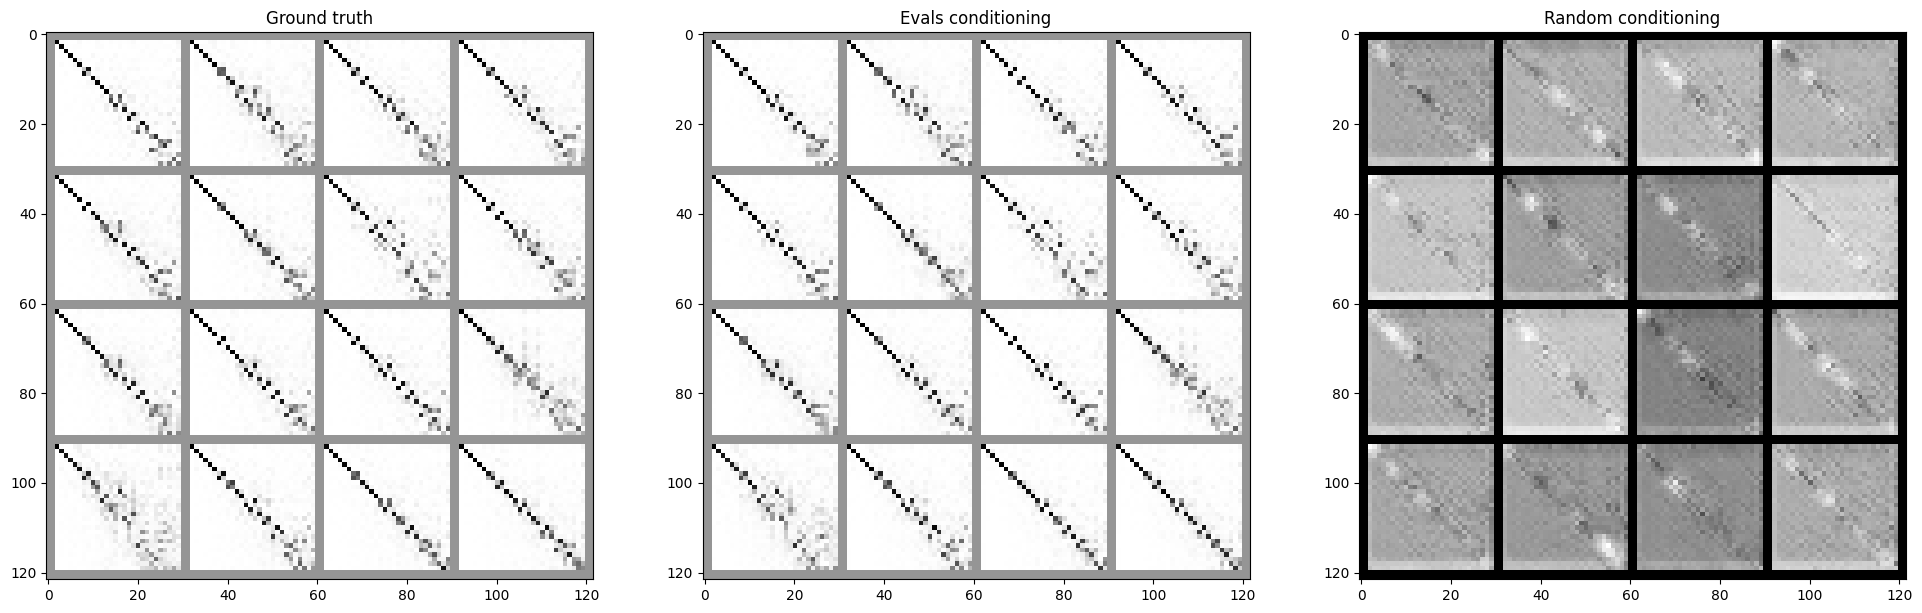

In [27]:
x_gt, x_cond_diag, x_rand_cond_diag = conditional_sampling(model_diag_conditional, rand_indices)

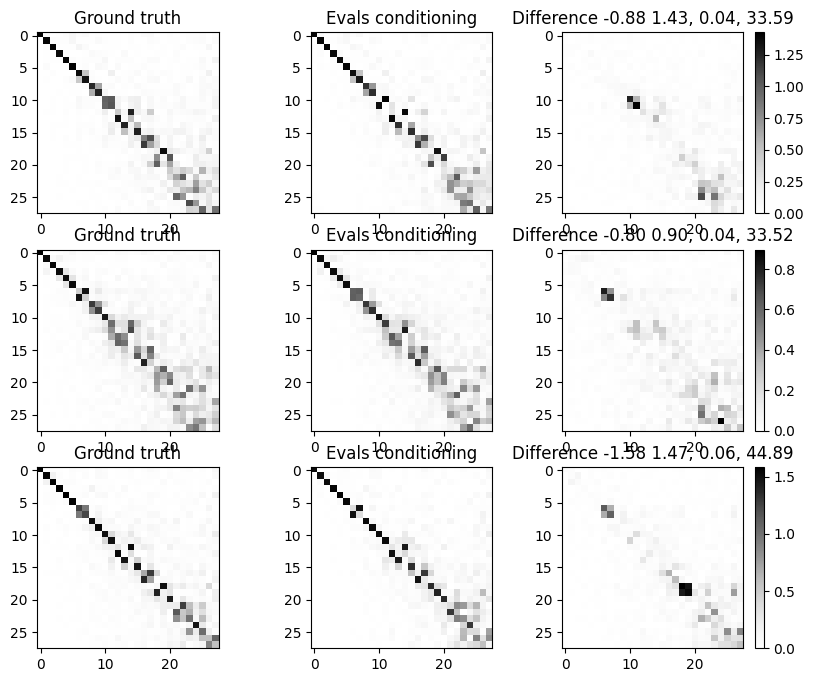

In [28]:
plot_sampling_difference(x_gt, x_cond_diag, rand_idx)